In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sales = pd.read_csv("housing.csv")
sales = sales.drop(columns=['Zip Code', 'Address', 'City', 'Zip Code Population','County','Latitude','Longitude'])
sales.head()

,Price,Beds,Baths,Living Space,State,Density,Income
0,3999000.0,2,3,1967,New York,20967.9,370046.0
1,3999000.0,2,3,1967,New York,20967.9,370046.0
2,1650000.0,1,1,718,New York,23740.9,249880.0
3,760000.0,3,2,1538,New York,23740.9,249880.0
4,1100000.0,1,1,600,New York,23740.9,249880.0


In [82]:
df = pd.read_csv("qol_states_2024.csv")
df.head()

,state,Score,Life,Affordability,Economy,Education And Health,Safety
0,Alabama,45.61,40,1,40,48,32
1,Alaska,40.93,50,42,22,30,45
2,Arizona,48.31,21,25,14,39,40
3,Arkansas,42.42,46,4,34,45,47
4,California,52.03,2,50,15,24,27


In [83]:
# 合并两个数据集
data = pd.merge(
    sales,
    df,
    left_on='State',  # Housing.csv 的州列
    right_on='state',  # qol_states_2024.csv 的州列
    how='inner'  # 使用内连接，保留两个数据集中共有的州
)
data = data[data['State'] != 'District of Columbia']
data = data.drop(columns=['state','Score'])
# 查看合并后的结果
data.head()

,Price,Beds,Baths,Living Space,State,Density,Income,Life,Affordability,Economy,Education And Health,Safety
0,3999000.0,2,3,1967,New York,20967.9,370046.0,1,46,37,16,2
1,3999000.0,2,3,1967,New York,20967.9,370046.0,1,46,37,16,2
2,1650000.0,1,1,718,New York,23740.9,249880.0,1,46,37,16,2
3,760000.0,3,2,1538,New York,23740.9,249880.0,1,46,37,16,2
4,1100000.0,1,1,600,New York,23740.9,249880.0,1,46,37,16,2


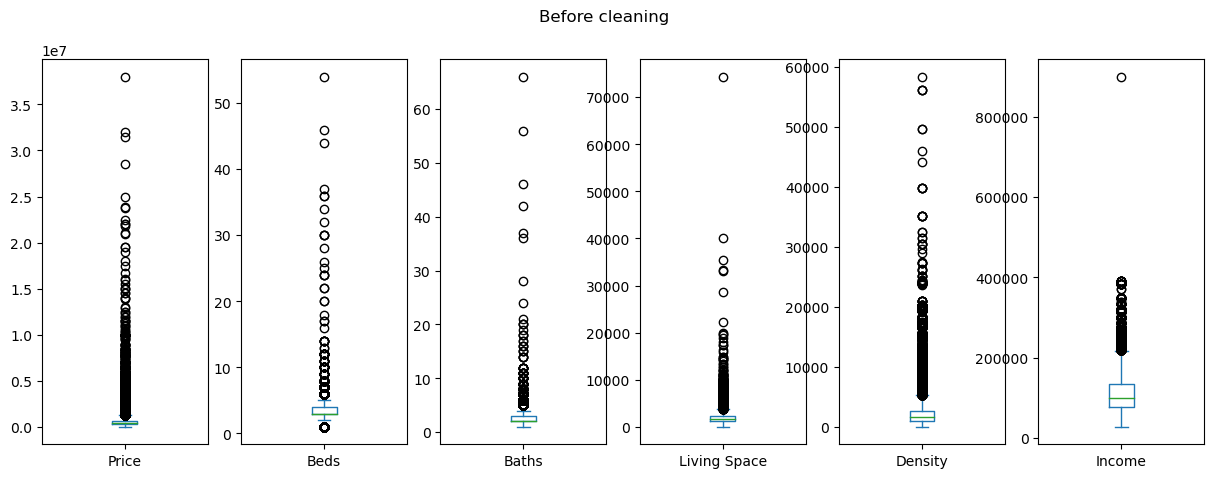

In [84]:
continuous_vars = ['Price', 'Beds', 'Baths', 'Living Space', 'Density','Income']
data[continuous_vars].plot(kind='box', subplots=True, layout=(1, len(continuous_vars)), figsize=(15, 5))
plt.suptitle("Before cleaning")
plt.show()

In [85]:
# 移除异常值
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
data = remove_outliers(data, continuous_vars)

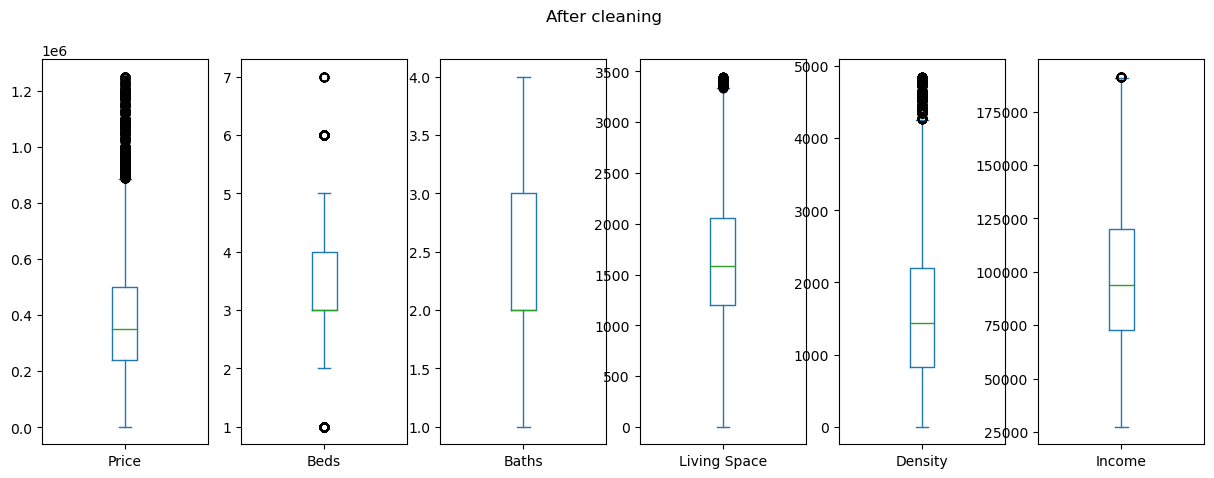

In [86]:
data[continuous_vars].plot(kind='box', subplots=True, layout=(1, len(continuous_vars)), figsize=(15, 5))
plt.suptitle("After cleaning")
plt.show()

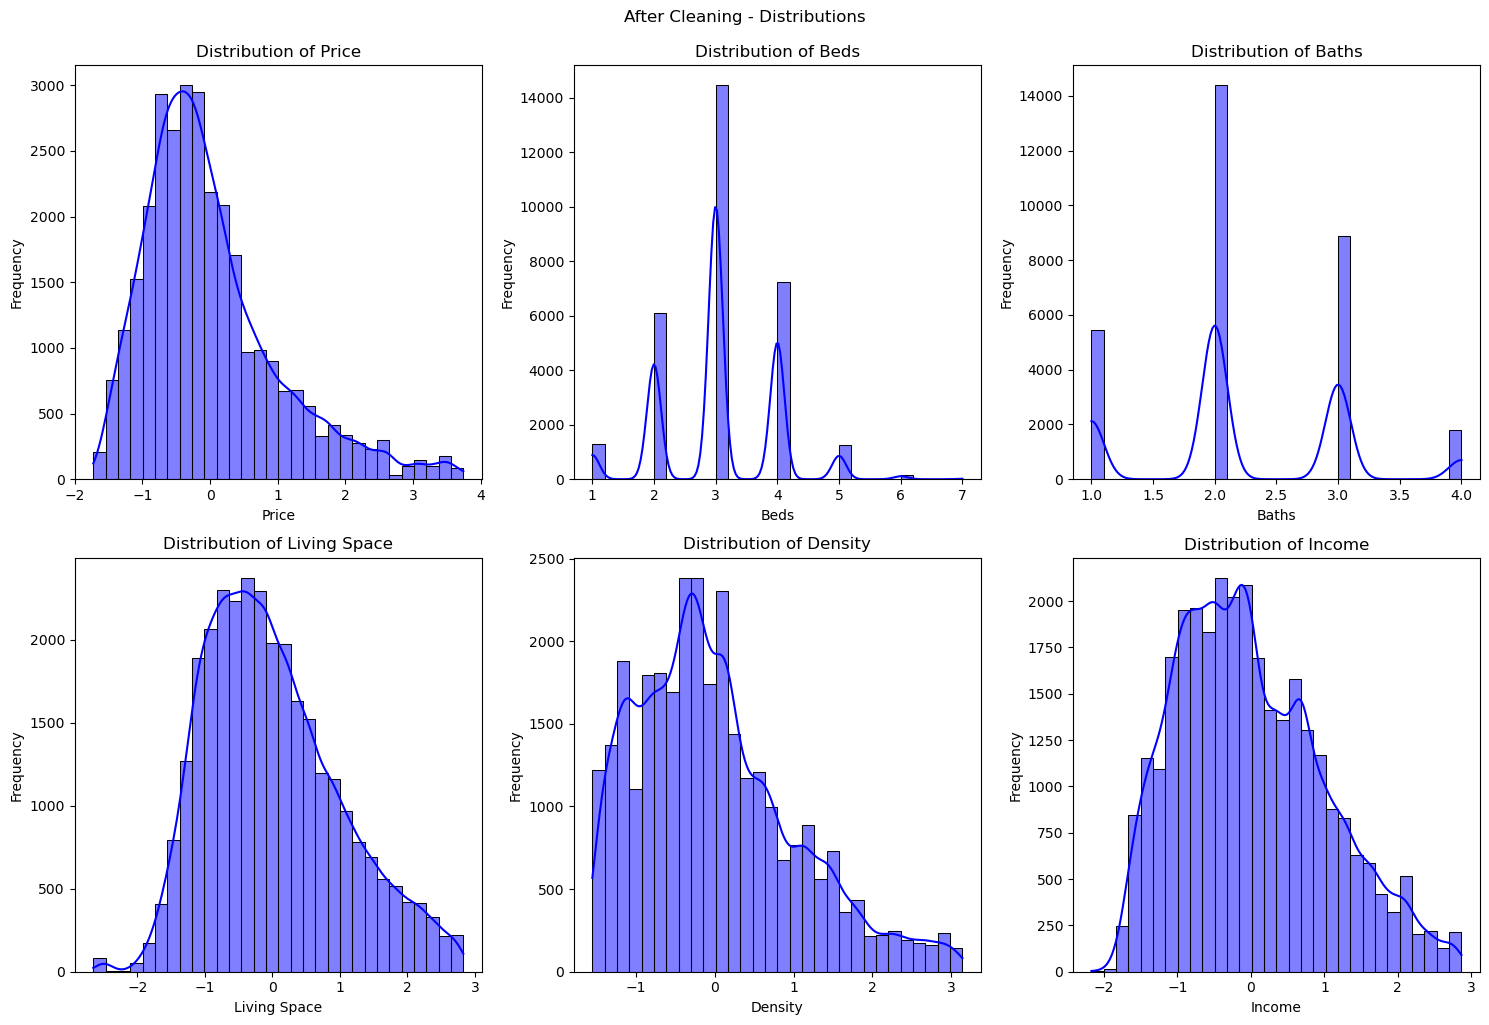

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
# 画分布图
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, (len(continuous_vars) + 1) // 2, i)
    sns.histplot(data[col], kde=True, bins=30, color='blue')  # 直方图 + 密度曲线
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle("After Cleaning - Distributions", y=1.02)
plt.show()

In [87]:
# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = ['Price','Living Space','Income','Density']
data[columns] = scaler.fit_transform(data[columns])
data.describe()

,Price,Beds,Baths,Living Space,Density,Income,Life,Affordability,Economy,Education And Health,Safety
count,3.051100e+04,30511.000000,30511.000000,3.051100e+04,3.051100e+04,3.051100e+04,30511.000000,30511.000000,30511.000000,30511.000000,30511.000000
mean,1.541150e-15,3.054177,2.229884,5.880969e-17,1.456157e-15,-7.278400e-15,17.905903,27.194586,24.590344,30.644948,31.028842
std,1.000016e+00,0.908127,0.807284,1.000016e+00,1.000016e+00,1.000016e+00,11.547674,12.603067,11.348964,10.803845,10.467027
min,-1.727642e+00,1.000000,1.000000,-2.652139e+00,-1.552692e+00,-2.170443e+00,1.000000,3.000000,4.000000,9.000000,2.000000
25%,-6.838579e-01,3.000000,2.000000,-7.476010e-01,-7.531440e-01,-7.815221e-01,11.000000,17.000000,15.000000,24.000000,25.000000
50%,-2.034102e-01,3.000000,2.000000,-1.350303e-01,-1.655572e-01,-1.320265e-01,15.000000,28.000000,23.000000,35.000000,33.000000
75%,4.522441e-01,4.000000,3.000000,6.143744e-01,5.748544e-01,6.700889e-01,27.000000,34.000000,32.000000,39.000000,40.000000
max,3.745866e+00,7.000000,4.000000,2.827584e+00,3.140841e+00,2.865860e+00,47.000000,50.000000,50.000000,49.000000,50.000000


In [88]:
# 第一次训练
from sklearn.model_selection import train_test_split
predictors = ['Beds', 'Baths', 'Living Space', 'Density', 'Income', 'Life', 'Affordability', 'Education And Health', 'Safety']
X = data[predictors]
y = data['Price']
# 分割数据（80%训练，20%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# 线性回归
X_train_sm = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train_sm)   
results = model.fit()                 

# 预测
X_test_sm = sm.add_constant(X_test)
y_pred = results.predict(X_test_sm)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(results.summary())

Mean Squared Error: 0.4629
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     3084.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:59:42   Log-Likelihood:                -25462.
No. Observations:               24408   AIC:                         5.094e+04
Df Residuals:                   24398   BIC:                         5.102e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const

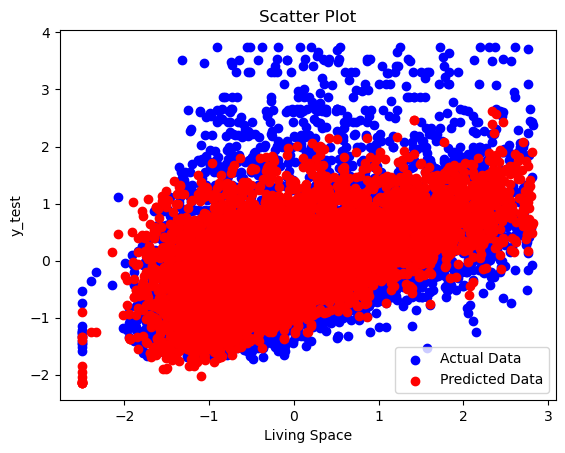

In [90]:
import matplotlib.pyplot as plt
X_feature = X_test["Living Space"]
plt.scatter(X_feature, y_test, color='blue', label='Actual Data')
plt.scatter(X_feature, y_pred, color='red', label='Predicted Data')

# 添加标题和标签
plt.title('Scatter Plot')
plt.xlabel(f'Living Space')
plt.ylabel('y_test')

# 显示图例
plt.legend()

# 显示图像
plt.show()



In [91]:
# 检查共线性
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictors = ['Beds', 'Baths', 'Living Space', 'Density', 'Income', 'Life', 'Affordability', 'Education And Health', 'Safety']
X = data[predictors]
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                Feature        VIF
0                  Beds  16.860295
1                 Baths  14.679019
2          Living Space   1.903754
3               Density   1.267583
4                Income   1.235192
5                  Life   6.573314
6         Affordability   8.347607
7  Education And Health  12.911510
8                Safety  10.770129


Beds, Baths, Life, Affordability, Education And Health, Safety都存在共线性

In [92]:
# 检查跟那些变量有共线性
correlation_matrix = X.corr()
print(correlation_matrix)

                          Beds     Baths  Living Space   Density    Income  \
Beds                  1.000000  0.510386      0.654817 -0.197430 -0.016584   
Baths                 0.510386  1.000000      0.701592 -0.187379  0.232845   
Living Space          0.654817  0.701592      1.000000 -0.240679  0.218532   
Density              -0.197430 -0.187379     -0.240679  1.000000  0.001541   
Income               -0.016584  0.232845      0.218532  0.001541  1.000000   
Life                  0.034132  0.023834      0.096549 -0.319100 -0.165564   
Affordability        -0.031348 -0.007238     -0.060676  0.318183  0.196008   
Education And Health  0.035815  0.041531      0.078612 -0.365128 -0.182144   
Safety               -0.001957  0.045603      0.097262 -0.233608  0.085515   

                          Life  Affordability  Education And Health    Safety  
Beds                  0.034132      -0.031348              0.035815 -0.001957  
Baths                 0.023834      -0.007238              

In [93]:
# 设一个高相关性的阈值
correlation_threshold = 0.7

# 查找高度相关的特征对
correlation_matrix = X.corr()
high_correlation_pairs = correlation_matrix.where((correlation_matrix.abs() > correlation_threshold) & (correlation_matrix != 1.0))
print(high_correlation_pairs)

                      Beds     Baths  Living Space  Density  Income      Life  \
Beds                   NaN       NaN           NaN      NaN     NaN       NaN   
Baths                  NaN       NaN      0.701592      NaN     NaN       NaN   
Living Space           NaN  0.701592           NaN      NaN     NaN       NaN   
Density                NaN       NaN           NaN      NaN     NaN       NaN   
Income                 NaN       NaN           NaN      NaN     NaN       NaN   
Life                   NaN       NaN           NaN      NaN     NaN       NaN   
Affordability          NaN       NaN           NaN      NaN     NaN -0.705181   
Education And Health   NaN       NaN           NaN      NaN     NaN       NaN   
Safety                 NaN       NaN           NaN      NaN     NaN       NaN   

                      Affordability  Education And Health  Safety  
Beds                            NaN                   NaN     NaN  
Baths                           NaN                  

In [94]:
# 特征合并
data['Avg_Space_Per_Bed'] = data['Living Space'] / (data['Beds'])
# 移除baths和Affordability，然后替换Living Space
predictors = ['Avg_Space_Per_Bed', 'Density', 'Income', 'Life', 'Education And Health', 'Safety']
X = data[predictors]
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                Feature        VIF
0     Avg_Space_Per_Bed   1.135137
1               Density   1.136261
2                Income   1.094396
3                  Life   4.748421
4  Education And Health  10.060664
5                Safety   8.307175


In [95]:
correlation_matrix = X.corr()
print(correlation_matrix)

                      Avg_Space_Per_Bed   Density    Income      Life  \
Avg_Space_Per_Bed              1.000000 -0.260106  0.124730  0.097622   
Density                       -0.260106  1.000000  0.001541 -0.319100   
Income                         0.124730  0.001541  1.000000 -0.165564   
Life                           0.097622 -0.319100 -0.165564  1.000000   
Education And Health           0.084620 -0.365128 -0.182144  0.489953   
Safety                         0.067434 -0.233608  0.085515  0.279370   

                      Education And Health    Safety  
Avg_Space_Per_Bed                 0.084620  0.067434  
Density                          -0.365128 -0.233608  
Income                           -0.182144  0.085515  
Life                              0.489953  0.279370  
Education And Health              1.000000  0.349832  
Safety                            0.349832  1.000000  


In [96]:
from sklearn.ensemble import RandomForestRegressor

# 训练随机森林模型，评估特征重要性
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 输出特征重要性
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


                Feature  Importance
2                Income    0.349214
0     Avg_Space_Per_Bed    0.310941
3                  Life    0.133338
1               Density    0.129532
5                Safety    0.049503
4  Education And Health    0.027471


In [97]:
# 第二次训练
predictors = ['Avg_Space_Per_Bed', 'Density', 'Income', 'Life', 'Safety']
X = data[predictors]
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# 线性回归
X_train_sm = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train_sm)   
results = model.fit()                 

# 预测
X_test_sm = sm.add_constant(X_test)
y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)
print(f"R² value (Variance Explained): {r_squared:.4f}")
print(results.summary())

R² value (Variance Explained): 0.4765
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     4748.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:59:56   Log-Likelihood:                -26441.
No. Observations:               24408   AIC:                         5.289e+04
Df Residuals:                   24402   BIC:                         5.294e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------


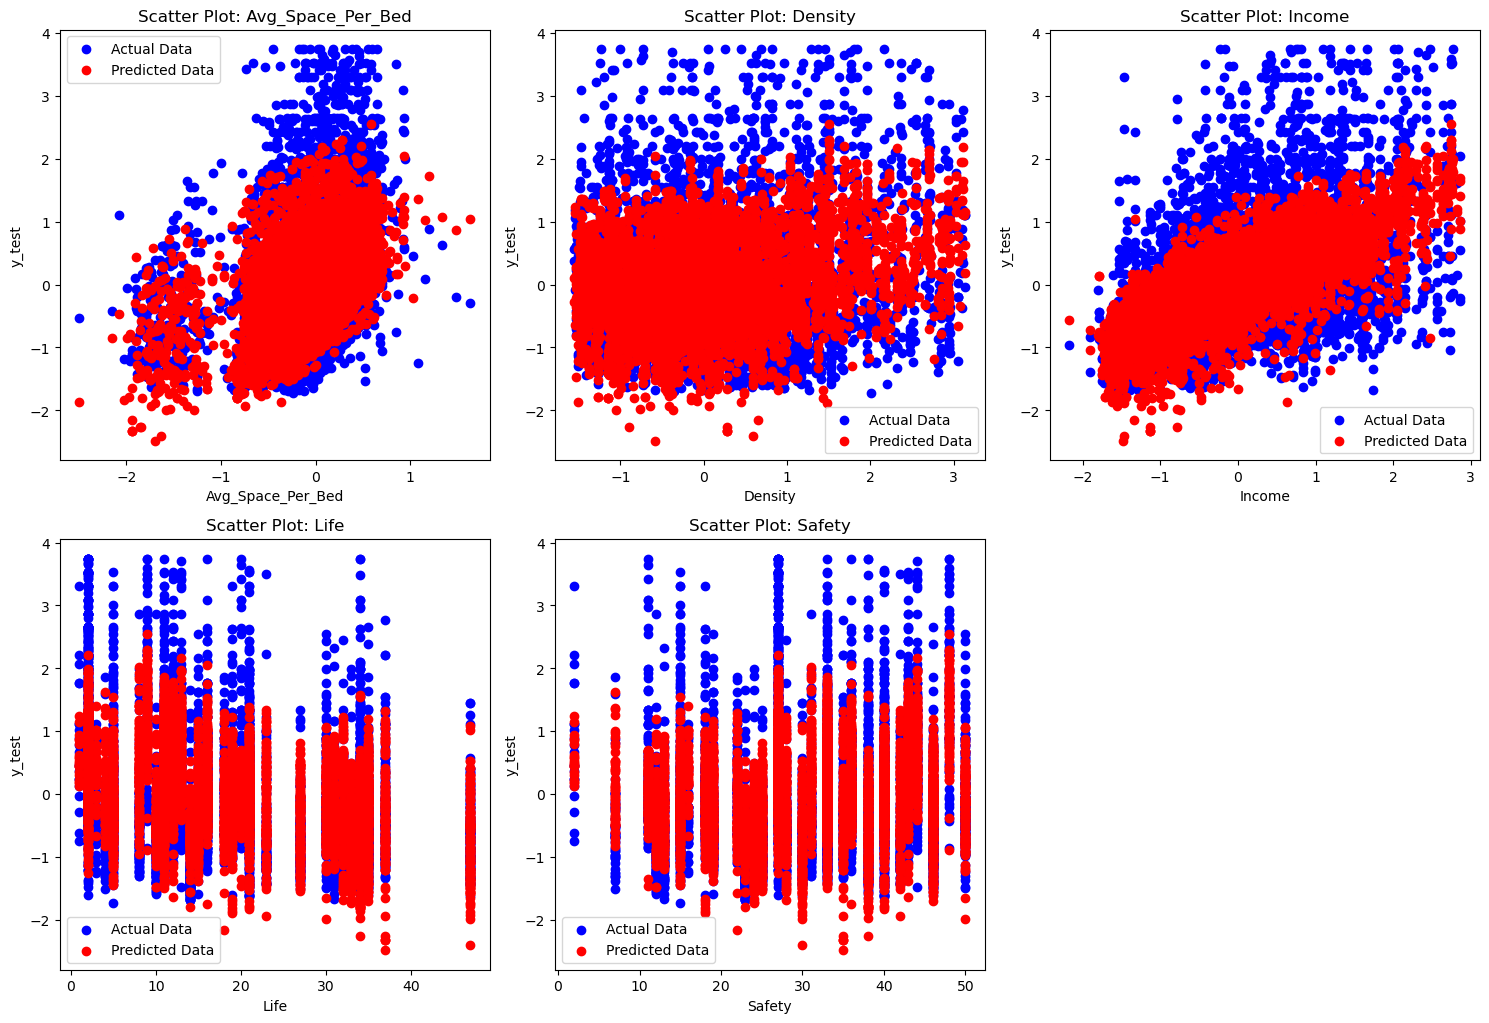

In [74]:
import matplotlib.pyplot as plt

# 假设 X_test 是一个 Pandas DataFrame
features = X_test.columns  # 获取所有特征的名称
n_features = len(features)  # 特征数量

# 创建子图，固定为 3x3 布局
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# 展平 axes 数组，方便逐个子图操作
axes = axes.flatten()

# 遍历每个特征
for i, feature in enumerate(features):
    X_feature = X_test[feature]  # 当前特征的值
    
    # 绘制散点图
    axes[i].scatter(X_feature, y_test, color='blue', label='Actual Data')
    axes[i].scatter(X_feature, y_pred, color='red', label='Predicted Data')
    
    # 设置标题和标签
    axes[i].set_title(f'Scatter Plot: {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('y_test')
    axes[i].legend()

# 隐藏多余的子图（如果有）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()

In [75]:
# 使用随机森林
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# 初始化
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,    
    random_state=42,   
)

rf_model.fit(X_train, y_train)

# 预测
y_pred = rf_model.predict(X_test)

# 评估模型性能
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r_squared:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R²: 0.7369
Mean Squared Error: 0.2544


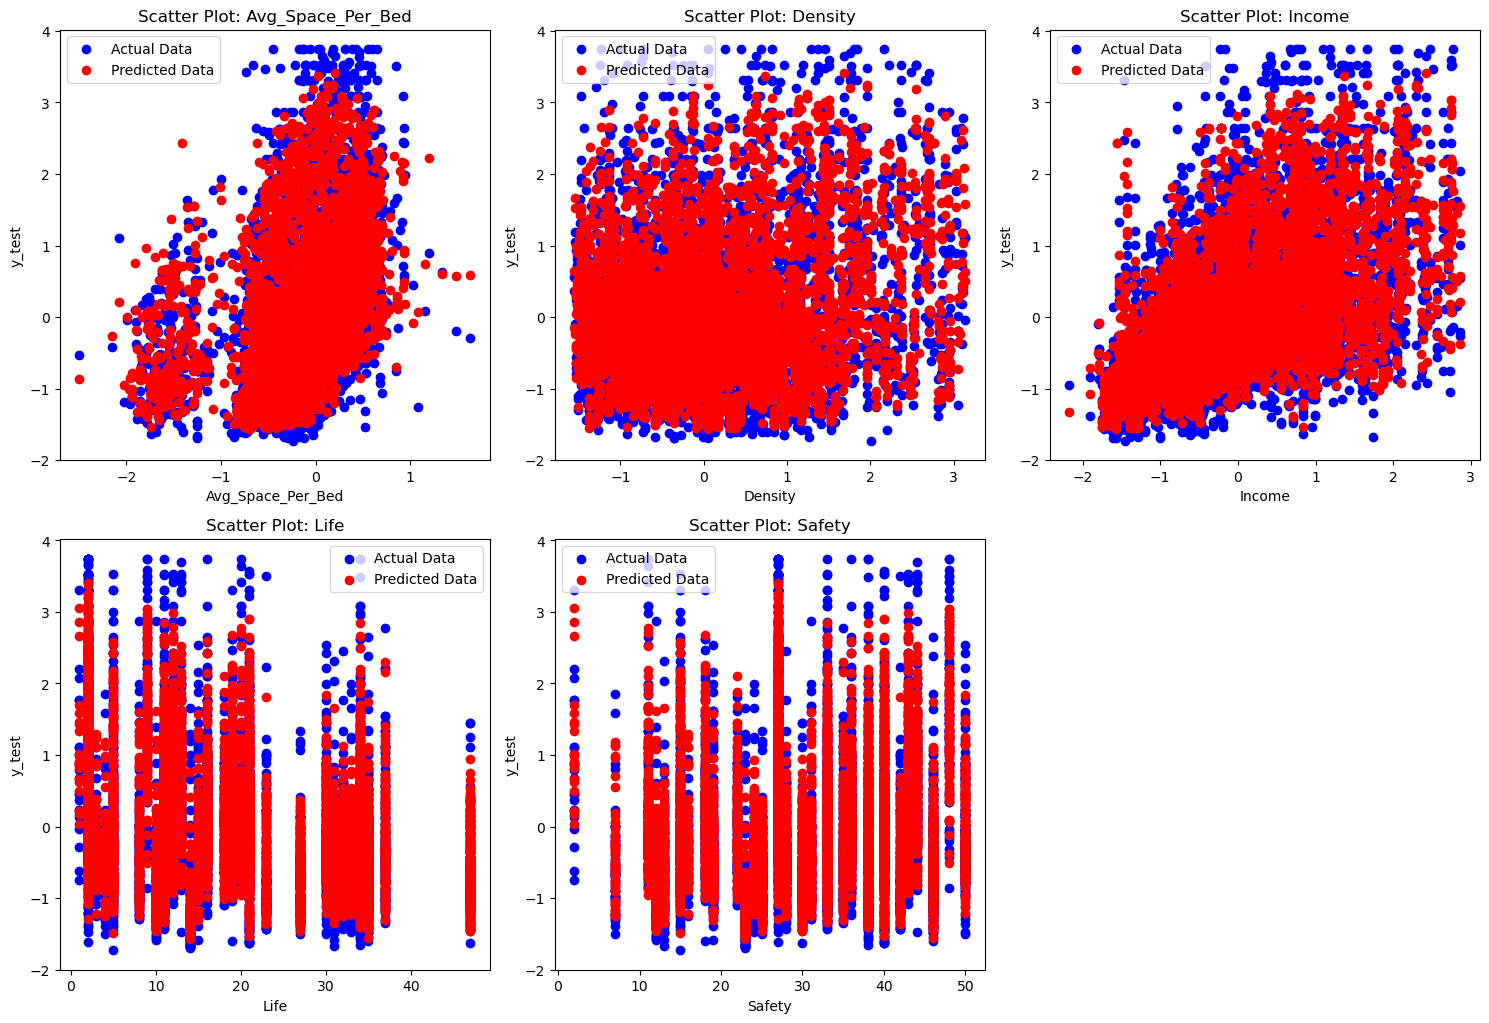

In [76]:
import matplotlib.pyplot as plt

# 假设 X_test 是一个 Pandas DataFrame
features = X_test.columns  # 获取所有特征的名称
n_features = len(features)  # 特征数量

# 创建子图，固定为 3x3 布局
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# 展平 axes 数组，方便逐个子图操作
axes = axes.flatten()

# 遍历每个特征
for i, feature in enumerate(features):
    X_feature = X_test[feature]  # 当前特征的值
    
    # 绘制散点图
    axes[i].scatter(X_feature, y_test, color='blue', label='Actual Data')
    axes[i].scatter(X_feature, y_pred, color='red', label='Predicted Data')
    
    # 设置标题和标签
    axes[i].set_title(f'Scatter Plot: {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('y_test')
    axes[i].legend()

# 隐藏多余的子图（如果有）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()

对照组

In [26]:
predictors = ['Living Space', 'Density', 'Income']
X = data[predictors]
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 线性回归
X_train_sm = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train_sm)   
results = model.fit()                 

# 预测
X_test_sm = sm.add_constant(X_test)
y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² value (Variance Explained): {r_squared:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(results.summary())

R² value (Variance Explained): 0.4521
Mean Squared Error: 0.5298
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     7055.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:03:40   Log-Likelihood:                -27112.
No. Observations:               24408   AIC:                         5.423e+04
Df Residuals:                   24404   BIC:                         5.427e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

不合并数据的情况下，使用线性回归预测的R只有0.46，而合并的预测结果有0.53

In [41]:
# 使用随机森林
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# 初始化
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,    
    random_state=42,   
)

rf_model.fit(X_train, y_train)

# 预测
y_pred = rf_model.predict(X_test)

# 评估模型性能
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r_squared:.4f}")

R²: 0.7098
